In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

[0.0939913559855373, 0.07253404905011811, 0.06870102071231242, 0.051762820390314365, 0.027739542846618438, 0.025018460404952265, 0.02110738493950169, 0.01849711671473993, 0.004062743184464324, 0.002768503034764084, 0.001965599004336443, 0.0014246523708227976, 0.0006726699891722666]


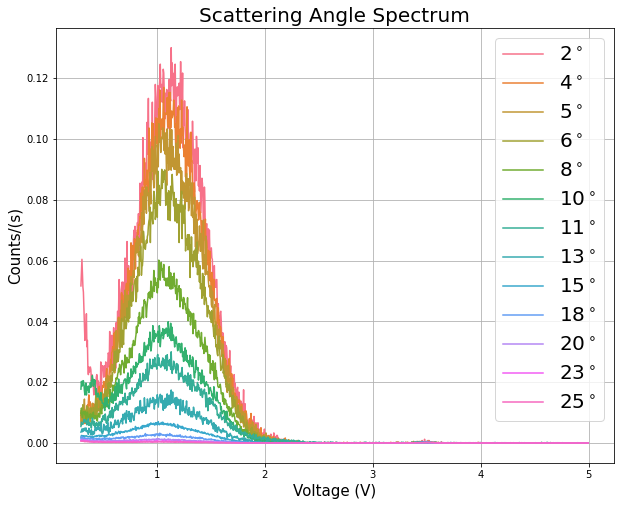

In [82]:
### THIS IS THE ONE ###
import seaborn as sns

time = 600 #seconds
samp_size = 5e6 #hz

angles = ['02','04','05', '06','08','10','11','13','15','18','20','23','25']

count_tot = []
fig, ax = plt.subplots(figsize=(10,8))
colors = sns.color_palette("husl", 13)
ax.set_prop_cycle('color', colors)
#fig, ax0 = plt.subplots(figsize=(10,8))
counts_s = []
count_err = []
ang_err = []

for angle in angles:
    path = f'./RUT/{angle}deg/' 
    list_dir = os.listdir(path)
    c, v = np.zeros(1024), np.zeros(1024) 
    filenum=0
    for file in list_dir:
        if file[-3:] == 'dat': 
            filenum+=1
            with open(path + file, 'r') as datFile:
                lines = [line.strip('\n') for line in datFile][3:]
                c += np.array([int(line.split('\t')[3]) for line in lines])
                v = np.array([float(line.split('\t')[2]) for line in lines] )

    c_norm = c/(filenum*time) # counts per s
    count_err.append(np.sqrt(sum(c))/(filenum*time))
    
    counts_s.append(sum(c_norm))
    count_tot.append(np.sum(np.array(c_norm)))
    
    histo =[]
    for i in range(len(v)):
        for j in range(int(c[i])):
            histo.append(v[i])

    bins = 50
    #h = ax0.hist(histo, bins = bins, histtype = 'step', label = f'{int(angle)}º')

    ax.plot(v, c_norm, label = f'{int(angle)}$^\circ$') 
    
ax.set_title(f"Scattering Angle Spectrum", fontsize = 20)
ax.grid(True)
ax.legend(fontsize = 20)
ax.set_xlabel("Voltage (V)", fontsize = 15)
ax.set_ylabel("Counts/(s)", fontsize = 15)

# ax0.grid(True)
# ax0.legend(fontsize = 20)

print(count_err)

# Calculate Atomic Number For Gold #

In [102]:
#background counts: 
time = 600 # seconds

path = f'./RUT/0deg_bkg/' 
list_dir = os.listdir(path)
c, v = np.zeros(1024), np.zeros(1024) 
filenum=0
for file in list_dir:
    if file[-3:] == 'dat': 
        filenum+=1
        with open(path + file, 'r') as datFile:
            lines = [line.strip('\n') for line in datFile][3:]
            c += np.array([int(line.split('\t')[3]) for line in lines])
            v = np.array([float(line.split('\t')[2]) for line in lines] )

c_norm_bkg = c/(filenum*time) # counts per s

bkg_tot = sum(np.array(c_norm_bkg))
print(bkg_tot)

bkg_err = np.sqrt(sum(c))/(filenum*time)
print(bkg_err)


60.0905555555556
0.1827119097795999


2.5299546632124353e-06


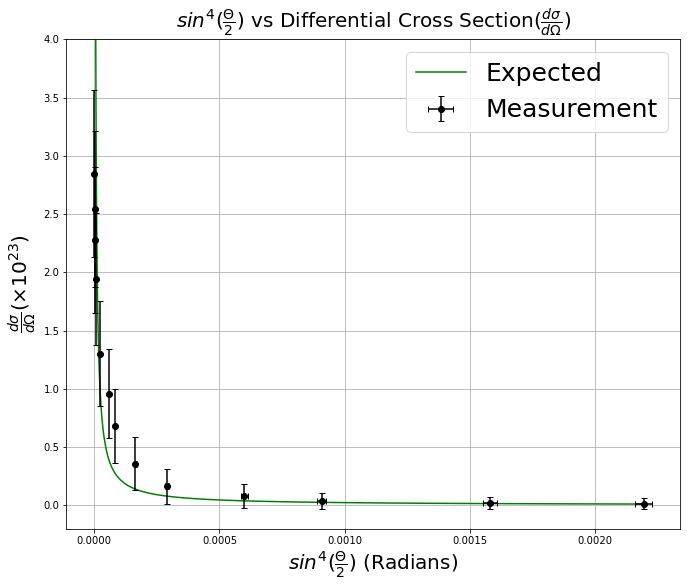

In [137]:
#plot counts vs theta 
from scipy.optimize import curve_fit

ang = np.array([2, 4, 5, 6, 8, 10, 11, 13, 15, 18, 20, 23, 25])

#print(count_tot)
fig, ax = plt.subplots(figsize = (11, 9))
ax.set_xlabel(r"$sin^4(\frac{\Theta}{2})$ (Radians)", fontsize = 20)
ax.set_ylabel(r"$ \frac{d\sigma}{d\Omega}(\times10^{23})$", fontsize = 20)
ax.set_title(r"$sin^4(\frac{\Theta}{2})$ vs Differential Cross Section($ \frac{d\sigma}{d\Omega}$)", fontsize = 20)

#fitting
h = 0.058 #meters #distance between the detector and the particle gun
r = 0.009525 #meters #radius of the detector
d_omega = 2*np.pi*(1-(h/np.sqrt(r**2+h**2)))
epsilon0 = 8.854e-12 #Farads/meters
coulomb = 1/(4*np.pi*epsilon0)
z_alpha = 2 #atomic number of alpha particles
e = 1.602e-19 #coulombs 
energy = 3.77 * 1.6033e-13#eV

constant = (coulomb * (z_alpha*e**2)/(4*energy))**2 #times z_gold -- unknown

#cross_section = (z_gold*constant)/(np.sin(theta/2)**4)
density_gold = 19300e3 #g/m^3
mass_goldFoil = 32e-3 #g
length_width_goldFoil = 25.6e-3 # m
t = mass_goldFoil/((length_width_goldFoil)**2 * density_gold)#thickness of gold foil
N0 = 6.022e23 #1/mol avagadros number
A = 197 #atomic weight of gold
area = density_gold*t

N = mass_goldFoil/(length_width_goldFoil)**2 *(N0/A)

# def eq(theta, z_gold):
#     cross_section = (z_gold**2*constant)/(np.sin(np.radians(theta)/2)**4)
#     return bkg_tot*N*cross_section*d_omega

# count_tot = big constant * 1/sin^4

z_gold = 79

ANG = np.linspace(np.radians(5), np.radians(25), 100)

cross_section = count_tot/(bkg_tot*N*d_omega)
expected_cross = (z_gold**2*constant)/(np.sin(ANG/2)**4)

theta_err = np.radians(1/10)
xerr = []
for i in range(len(ang)):
    error = (2*np.cos(np.radians(ang[i])/2))*(np.sin(np.radians(ang[i])/2)**3)
    xerr.append(error*theta_err)
    
xerr2 = []
for i in range(len(ang)):
    error = (2*np.cos(np.radians(ang[i])/2))/(np.sin(np.radians(ang[i])/2)**5)
    xerr2.append(error*theta_err)
    
yerr = []
sigma_counts = (np.sqrt(count_tot))
sigma_bkgCounts = np.sqrt(bkg_tot)
sigma_h = 1e-100
sigma_r = 1e-100
sigma_mass = 1e-100
sigma_area = 1e-100
for i in range(len(ang)):
    term1 = (1/(bkg_tot*N*d_omega))**2 * (sigma_counts[i])**2
    term2 = (count_tot[i]/(bkg_tot**2*N*d_omega))**2 * (sigma_bkgCounts)**2
    term3 = (2*np.pi*count_tot[i]/(bkg_tot*N))**2 * (r**2/((h**2 + r**2)**(3/2)))**2 * sigma_h**2
    term4 = (2*np.pi*count_tot[i]/(bkg_tot*N))**2 * (h*r/((r**2 + h**2)**(3/2)))**2 * sigma_r**2
    term5 = (count_tot[i]*N0/(bkg_tot*d_omega*A))**2 * (1/area)**2 * sigma_mass**2
    term6 = (count_tot[i]*N0/(bkg_tot*d_omega*A))**2 * (mass_goldFoil/area**2)**2 * sigma_area**2
    yerr.append(np.sqrt(term1 + term2 + term3 + term4 + term5 + term6))
    


y_extra = 1e23

#ax.scatter(np.sin(np.radians(ang)/2)**4, cross_section, color = 'black', label = 'Measured')
ax.plot(np.sin(ANG/2)**4, expected_cross*y_extra, color = 'green', label = 'Expected')
#ax.set_yscale('log')
ax.grid(True)

#error: 
ax.errorbar(np.sin(np.radians(ang)/2)**4, cross_section*y_extra,xerr = xerr, yerr = np.array(yerr)*y_extra, fmt = "o", capsize = 3, color = 'black', label = "Measurement")
#ax.set_xlim(-.0001, .001)

ax.legend(fontsize =25)
ax.set_ylim(-.2, 4)

print(t)


(13,) (13,)
2.74 &
2.44 &
2.19 &
1.87 &
1.25 &
0.92 &
0.66 &
0.34 &
0.16 &
0.07 &
0.04 &
0.02 &
0.01 &


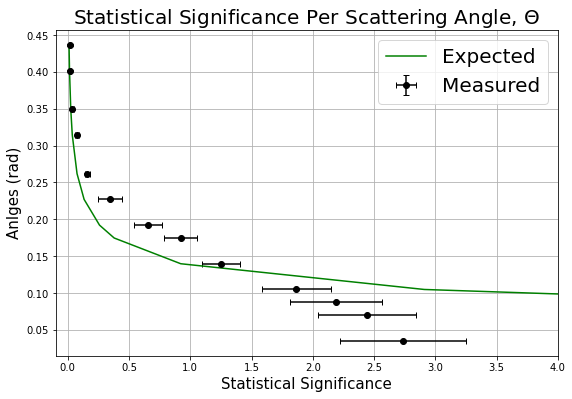

In [118]:
ang = np.array([2, 4, 5, 6, 8, 10, 11, 13, 15, 18, 20, 23, 25])

fig, axx = plt.subplots(figsize =(9, 6))
ang_err = []
#error for counts is count_err
signif_err = count_err/bkg_err

for i in range(len(ang)):
    ang_err.append(np.radians(1/10)*np.radians(ang[i]))
significance = counts_s/np.sqrt(bkg_tot)
print(np.shape(ang_err), np.shape(count_err))
axx.errorbar(significance, np.radians(ang), xerr = signif_err, yerr = ang_err, fmt = "o", capsize = 3, color = 'black', label = "Measured")
axx.grid(True)
axx.set_title(r"Statistical Significance Per Scattering Angle, $\Theta$", fontsize = 20)
axx.set_xlabel("Statistical Significance", fontsize = 15)
axx.set_ylabel(r"Anlges (rad)", fontsize = 15)

expected_cross = (79**2*constant)/(np.sin(np.radians(ang)/2)**4)
sig_back = N*expected_cross*d_omega * np.sqrt(bkg_tot)

axx.plot(sig_back, np.radians(ang), color = 'green', label = 'Expected')
axx.set_xlim(-.1, 4)
axx.legend(fontsize = 20)

for i in range(len(ang)):
    print(f"{significance[i]:0.2f} &")

[2.2428698907014036e+18, 1.740089238430132e+18, 1.1452145211465766e+18, 2.999617245934943e+17, 1.6770160988061466e+18, 3.060011085012993e+18]
0 & 2.762 & 0.230 \
1 & 9.274 & 0.843 \
2 & 9.656 & 0.966 \
3 & 10.328 & 1.148 \
4 & 4.714 & 0.589 \
5 & 1.062 & 0.152 \


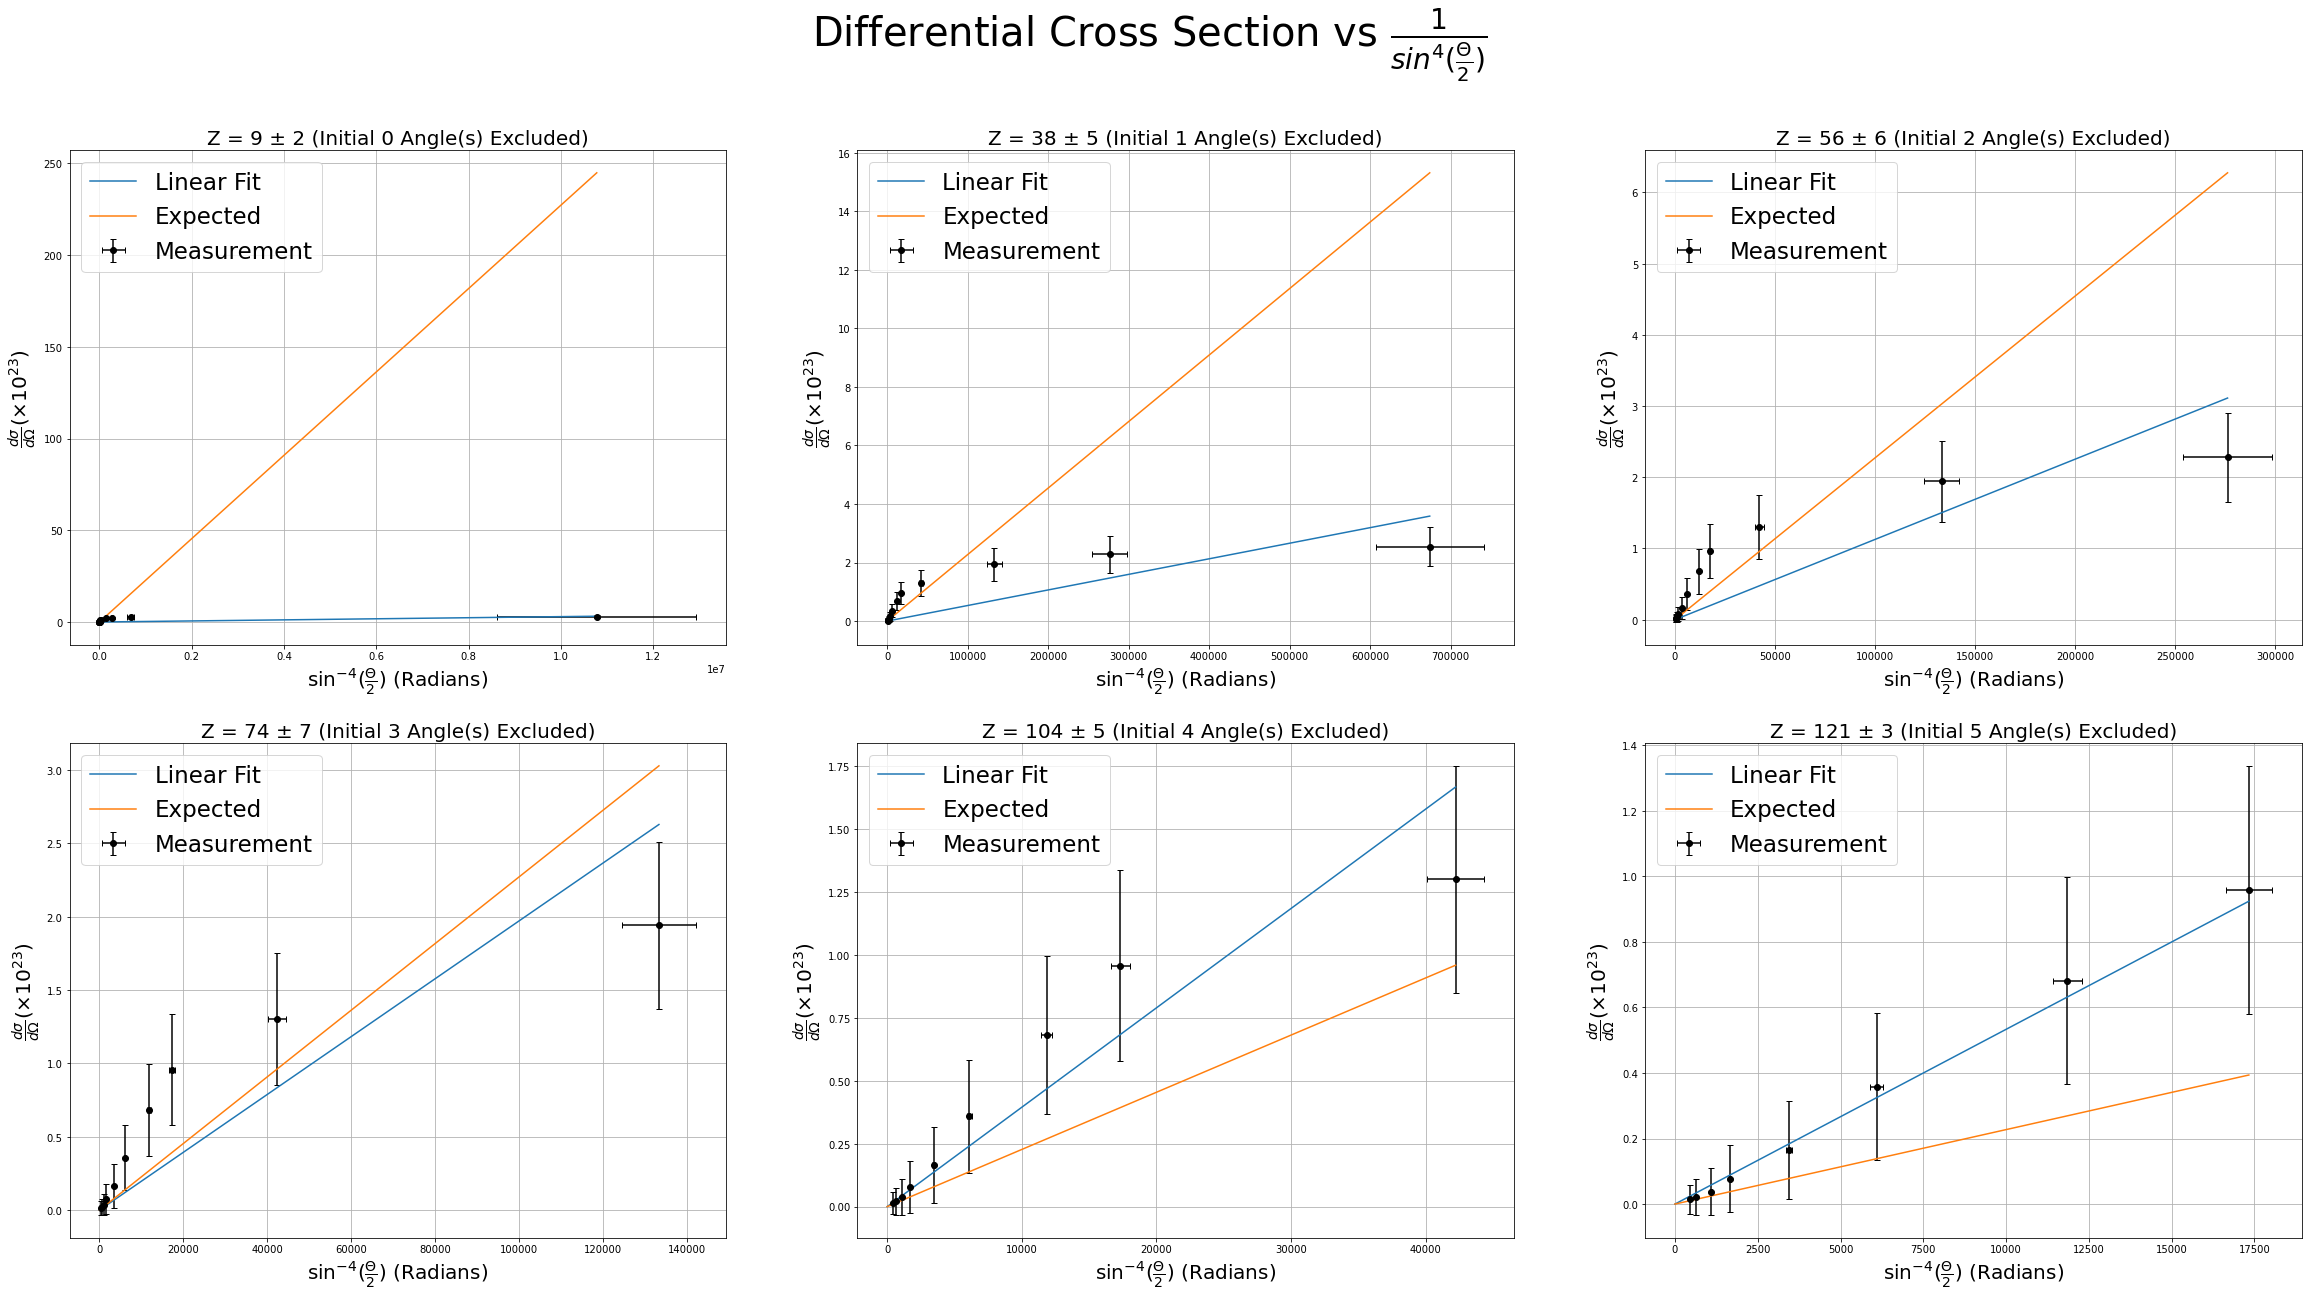

In [136]:
#FOR Calculating the gold atomic number: 
fig, ax1 = plt.subplots(2, 3, figsize = (40, 20))

anglim = [0, 1, 2, 3, 4, 5]
diffSlope = []
zGold = []
zGoldErr = []
chi2_x = []
rchi2_x = []
chi2_y = []
rchi2_y = []
for i in range(len(ax1.flat)):
    ax = ax1.flat[i]

    xdata = 1/(np.sin(np.radians(ang[anglim[i]:])/2)**4)
    ydata = cross_section[anglim[i]:]*y_extra
    ax.errorbar(xdata, ydata, xerr = xerr2[anglim[i]:], yerr = np.array(yerr[anglim[i]:])*y_extra, fmt = "o", capsize = 3, color = 'black', label = "Measurement")

    def eqs(x, zG):
        crossSection = (zG**2*constant*y_extra)*x
        return crossSection

    params, cov = curve_fit(eqs, xdata, ydata, sigma=yerr[anglim[i]:], absolute_sigma=False)
    #print(params)
    xp = np.linspace(0, xdata[0], 100)
    ax.plot(xp, eqs(xp, params[0]), label = "Linear Fit")
    slope_fit = abs((eqs(xp, params[0])[anglim[i]] - eqs(xp, params[0])[len(ang) - 1])*y_extra/(xp[anglim[i]]-xp[len(ang) - 1]))
    ax.plot(xp, 79**2*constant*y_extra*xp, label = "Expected")
    
    yE = 79**2*constant*y_extra*xp
    slope_exp = abs((yE[anglim[i]] - yE[len(ang) - 1])*y_extra/(xp[anglim[i]]-xp[len(ang) - 1]))
    
    diffSlope.append(abs(slope_exp - slope_fit))
    zGold.append(params[0])
    zGoldErr.append(np.sqrt(cov[0][0]))
    
    ax.set_xlabel(r"$\sin^{-4}(\frac{\Theta}{2})$ (Radians)", fontsize = 20)
    ax.set_ylabel(r"$ \frac{d\sigma}{d\Omega}(\times 10^{23})$", fontsize = 20)
    ax.grid(True)
    ax.legend(fontsize = 23)
    
    #chi^2 calculation: 
    observedy = np.mean(ydata)
    expectedy = np.mean(eqs(xp, params[0]))
    chi2y = ((observedy-expectedy))**2/(np.mean(np.array(yerr[anglim[i]:])*y_extra)**2)
    reduced_chi2y = chi2y/(len(ydata) - 1)
    
    observedx = np.mean(xdata)
    expectedx = np.mean(xp)
    chi2x = ((observedx-expectedx))**2/(np.mean(xerr2[anglim[i]:])**2)
    reduced_chi2x = chi2x/(len(xdata) - 1)
    
    chi2_x.append(chi2x)
    chi2_y.append(chi2y)
    rchi2_x.append(reduced_chi2x)
    rchi2_y.append(reduced_chi2y)
    
    #print(reduced_chi2)
    
    ax.set_title(f"Z = {round(params[0])} ± {round(np.sqrt(cov[0][0]))} (Initial {anglim[i]} Angle(s) Excluded)", fontsize = 20)


    
fig.suptitle(r"Differential Cross Section vs $\frac{1}{sin^4(\frac{\Theta}{2})}$", fontsize = 40)

print(diffSlope)

for i in range(len(chi2_x)):
    print(f"{anglim[i]} & {chi2_y[i]:0.3f} & {rchi2_y[i]:0.3f} \\")


In [13]:
import random as rand

num = rand.randint(0,1)

if (num == 1):
    print('yes')
else:
    print('no')

yes


97